# Importing Libraries

In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

from tqdm import tqdm

# Kaggle Configurations

In [2]:
train_data = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
test_data = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')

In [3]:
train_data.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

In [4]:
target = 'Transported'

# Data Preprocessing

In [5]:
for col in train_data.columns:
  print(f'unique({col}) = {len(train_data[col].unique())}')

unique(PassengerId) = 8693
unique(HomePlanet) = 4
unique(CryoSleep) = 3
unique(Cabin) = 6561
unique(Destination) = 4
unique(Age) = 81
unique(VIP) = 3
unique(RoomService) = 1274
unique(FoodCourt) = 1508
unique(ShoppingMall) = 1116
unique(Spa) = 1328
unique(VRDeck) = 1307
unique(Name) = 8474
unique(Transported) = 2


In [6]:
# Function to split 'Cabin' field
def splitCabin(cabin):
    if pd.isnull(cabin):
        return pd.Series({'Deck': None, 'Num': None, 'Side': None})
    else:
        parts = cabin.split('/')
        deck = parts[0]
        num = parts[1]
        side = parts[2]
        return pd.Series({'Deck': deck, 'Num': num, 'Side': side})

In [7]:
def preprocessData(data: pd.DataFrame, isPred: bool = False):
  # filling nan cells with appropriate values
  data.Cabin.fillna('Z/0/N', inplace = True)
  data.HomePlanet.fillna('NULL', inplace = True)
  data.Destination.fillna('NULL', inplace = True)
  data.Age.fillna(data.Age.mean(), inplace = True)
  data.RoomService.fillna(data.RoomService.mean(), inplace = True)
  data.FoodCourt.fillna(data.FoodCourt.mean(), inplace = True)
  data.ShoppingMall.fillna(data.ShoppingMall.mean(), inplace = True)
  data.Spa.fillna(data.Spa.mean(), inplace = True)
  data.VRDeck.fillna(data.VRDeck.mean(), inplace = True)

  data[['Deck', 'Num', 'Side']] = data['Cabin'].apply(splitCabin)

  # removing unnecessary fields
  data.drop(columns = ['PassengerId', 'Name', 'Cabin'], inplace = True)

  # label encoding categorical fields
  cols2labelEncode = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side']

  if not isPred:
    cols2labelEncode.append(target)

  le = LabelEncoder()

  for col in cols2labelEncode:
    data[col] = le.fit_transform(data[col])

  # zscoring all the fields
  cols2zscore = data.keys()
  if not isPred:
    cols2zscore = cols2zscore.drop(target)
  data[cols2zscore] = data[cols2zscore].astype(float).apply(stats.zscore)

  return data

In [8]:
def getFeaturesAndLabels(data: pd.DataFrame, isPred: bool = False):
  fields = data.keys()
  if not isPred:
    fields = fields.drop(target)

  features = data[fields].values.astype(float)
  labels = torch.Tensor(len(features)) if isPred else data[target].values.astype(int)

  # conversion to tensors
  featuresT = torch.Tensor(features)
  labelsT = torch.Tensor(labels)[:, None]

  return featuresT, labelsT

In [9]:
train_data = preprocessData(train_data)

/tmp/ipykernel_18/628609021.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data.Cabin.fillna('Z/0/N', inplace = True)
/tmp/ipykernel_18/628609021.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.me

In [10]:
train_data

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Side
0,0.325245,-0.741736,0.622532,0.709437,-0.208465,-0.340590,-0.287314,-0.290817,-0.276663,-0.269023,0,-1.839907,-1.141624,-0.866174
1,-0.833031,-0.741736,0.622532,-0.336717,-0.208465,-0.175364,-0.281669,-0.248968,0.211505,-0.230194,1,0.331095,-1.141624,0.975267
2,0.325245,-0.741736,0.622532,2.034566,2.786879,-0.275409,1.955616,-0.290817,5.694289,-0.225782,0,-2.382658,-1.141624,0.975267
3,0.325245,-0.741736,0.622532,0.290975,-0.208465,-0.340590,0.517406,0.330225,2.683471,-0.098708,0,-2.382658,-1.141624,0.975267
4,-0.833031,-0.741736,0.622532,-0.894666,-0.208465,0.118709,-0.243409,-0.038048,0.225732,-0.267258,1,0.331095,-1.139678,0.975267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,0.325245,-0.741736,-1.852318,0.848924,2.786879,-0.340590,3.989682,-0.290817,1.184286,-0.203720,0,-2.382658,-0.950907,-0.866174
8689,-0.833031,1.115916,-0.202418,-0.755179,-0.208465,-0.340590,-0.287314,-0.290817,-0.276663,-0.269023,0,0.873845,1.775567,0.975267
8690,-0.833031,-0.741736,0.622532,-0.197230,-0.208465,-0.340590,-0.287314,2.842851,-0.275774,-0.269023,1,0.873845,1.777513,0.975267
8691,0.325245,-0.741736,-1.852318,0.221232,-0.208465,-0.340590,0.370637,-0.290817,0.037223,2.585740,0,-0.211656,0.041600,0.975267


# Correlation Visualization

<Axes: >

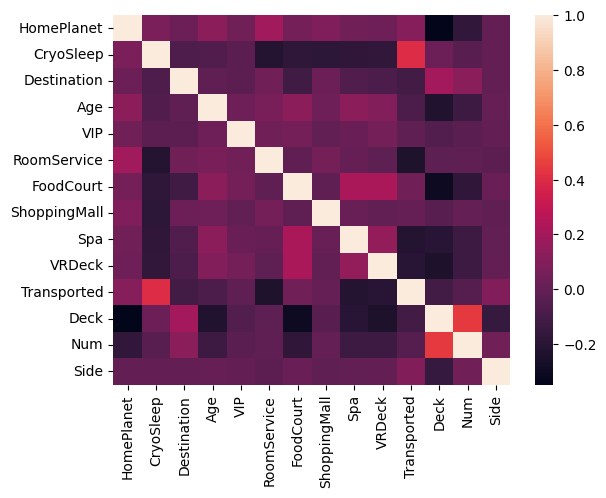

In [11]:
sns.heatmap(train_data.corr())

In [12]:
featuresT, labelsT = getFeaturesAndLabels(train_data)
train_data, dev_data, train_labels, dev_labels = train_test_split(featuresT, labelsT, shuffle = True, test_size = 0.2)
print(f'Train data: {len(train_data)} | Train labels: {len(train_labels)}')
print(f'Test data: {len(dev_data)} | Test labels: {len(dev_labels)}')

Train data: 6954 | Train labels: 6954
Test data: 1739 | Test labels: 1739


In [13]:
train_dataset = TensorDataset(train_data, train_labels)
dev_dataset = TensorDataset(dev_data, dev_labels)

batchsize = 32

train_dataloader = DataLoader(train_dataset, batch_size = batchsize, shuffle = True, drop_last = True)
dev_dataloader = DataLoader(dev_dataset, batch_size = dev_dataset.tensors[0].shape[0])

# Making the Network

In [14]:
def makeTheNet():

  class ANNnet(nn.Module):
    def __init__(self):
      super().__init__()

      self.input = nn.Linear(featuresT.shape[1], 256)

      self.fc1 = nn.Linear(256, 256)
      self.bn1 = nn.BatchNorm1d(256)

      self.fc2 = nn.Linear(256, 256)
      self.bn2 = nn.BatchNorm1d(256)

      self.fc3 = nn.Linear(256, 256)
      self.bn3 = nn.BatchNorm1d(256)

      self.fc4 = nn.Linear(256, 256)
      self.bn4 = nn.BatchNorm1d(256)

      self.fc5 = nn.Linear(256, 256)
      self.bn5 = nn.BatchNorm1d(256)

      self.output = nn.Linear(256, 1)

    def forward(self, x):
      x = F.relu( self.input(x) )
      x = F.dropout(x, .5)

      x = self.fc1(x)
      x = self.bn1(x)
      x = F.relu(x)
      x = F.dropout(x, .5)

      x = self.fc2(x)
      x = self.bn2(x)
      x = F.relu(x)
      x = F.dropout(x, .5)

      x = self.fc3(x)
      x = self.bn3(x)
      x = F.relu(x)
      x = F.dropout(x, .5)

      x = self.fc4(x)
      x = self.bn4(x)
      x = F.relu(x)
      x = F.dropout(x, .5)

      x = self.fc5(x)
      x = self.bn5(x)
      x = F.relu(x)
      x = F.dropout(x, .5)

      return self.output(x)

  net = ANNnet()

  lossfun = nn.BCEWithLogitsLoss()

  optimizer = torch.optim.Adam(net.parameters(), lr = .0001)

  return net, lossfun, optimizer

In [15]:
net, lossfun, optimizer = makeTheNet()

In [16]:
X, y = next(iter(train_dataloader))
yHat = net(X)
lossfun(yHat, y)

tensor(0.7179, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

# Training the Network

In [17]:
def functionToTrainNet():
  epochs = 300

  net, lossfun, optimizer = makeTheNet()

  trainAcc = []
  trainLoss = []
  devAcc = []
  devLoss = []

  for epochi in tqdm(range(epochs)):

    net.train()

    batchAcc = []
    batchLoss = []

    for X, y in train_dataloader:
      yHat = net(X)
      loss = lossfun(yHat, y)

      batchLoss.append(loss.item())
      batchAcc.append(torch.mean(((yHat > .0) == y).float()) * 100)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    trainAcc.append(np.mean(batchAcc))
    trainLoss.append(np.mean(batchLoss))

    net.eval()
    with torch.no_grad():
      X, y = next(iter(dev_dataloader))
      yHat = net(X)
      loss = lossfun(yHat, y)

      devLoss.append(loss.item())
      devAcc.append(torch.mean(((yHat > .0) == y).float()) * 100)

  return trainAcc, devAcc, trainLoss, devLoss, net

In [18]:
trainAcc, devAcc, trainLoss, devLoss, net = functionToTrainNet()

100%|██████████| 300/300 [07:53<00:00,  1.58s/it]


# Plotting the results for Train and Dev set

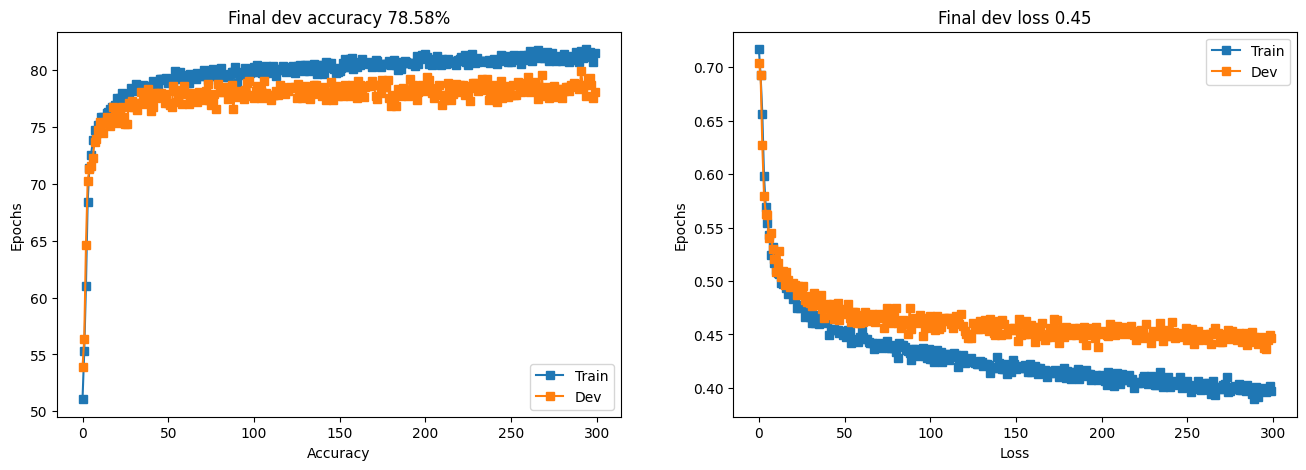

In [19]:
fig, ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainAcc, 's-', label = 'Train')
ax[0].plot(devAcc, 's-', label = 'Dev')
ax[0].set_title(f'Final dev accuracy {np.mean(devAcc[-10:]):.2f}%')
ax[0].set_xlabel('Accuracy')
ax[0].set_ylabel('Epochs')
ax[0].legend()

ax[1].plot(trainLoss, 's-', label = 'Train')
ax[1].plot(devLoss, 's-', label = 'Dev')
ax[1].set_title(f'Final dev loss {devLoss[-1]:.2f}')
ax[1].set_xlabel('Loss')
ax[1].set_ylabel('Epochs')
ax[1].legend()

plt.show()

# Predicting the Test data

In [20]:
passengerIds = test_data.PassengerId

In [21]:
test_data = preprocessData(test_data, True)

/tmp/ipykernel_18/628609021.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data.Cabin.fillna('Z/0/N', inplace = True)
/tmp/ipykernel_18/628609021.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.me

In [22]:
featuresT, labelsT = getFeaturesAndLabels(test_data, True)
test_dataset = TensorDataset(featuresT, labelsT)
test_dataloader = DataLoader(test_dataset, batch_size = test_dataset.tensors[0].shape[0], shuffle = False)

In [23]:
X, _ = next(iter(test_dataloader))
yHat = net(X)
yPred = (yHat > .0).squeeze().bool()

In [24]:
result = pd.DataFrame({
    'PassengerId': passengerIds,
    'Transported': yPred,
})
result

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [25]:
result.to_csv('spaceship-titanic.csv', index = False)